In [13]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import load_model
%matplotlib inline

In [9]:
Size=50 #Resizing Dataset Images To 50x50
train_dir = "./ASL_Alphabet/asl_alphabet_train/asl_alphabet_train/"
test_dir =  "./ASL_Alphabet/asl_alphabet_test/"
from tqdm import tqdm
#Loading in all the images
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (Size, Size, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir) 

#Splitting between testing and training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2) 
#creating labels
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 29)
y_testHot = to_categorical(y_test, num_classes = 29)

100%|██████████| 3000/3000 [00:15<00:00, 187.57it/s]


In [10]:
from sklearn.utils import shuffle
#Shuffle order of imported data
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

In [11]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#Printing of different accuracy plots
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None])
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [15]:
#Resize the arrays to fit the LSTM
x_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
x_val=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1],X_test.shape[2],X_test.shape[3]))

In [16]:
def get_model():
    model = keras.models.Sequential()
    model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu'),input_shape=(None, 50, 50,3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100,return_sequences=False))
    model.add(Dense(29,activation='sigmoid'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
model = get_model()
model.summary()

history = model.fit(
    x_train, y_trainHot, validation_data=(x_val, y_testHot), batch_size=100, epochs=5
)

model.save('RNN_model.h5')  # creates a HDF5 file 'RNN_model.h5'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 48, 48, 64)  1792     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 24, 24, 64)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 22, 22, 32)  18464    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 11, 11, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 3872)       0

544/544 - 9s - loss: 0.1516 - accuracy: 0.9702 - 9s/epoch - 17ms/step


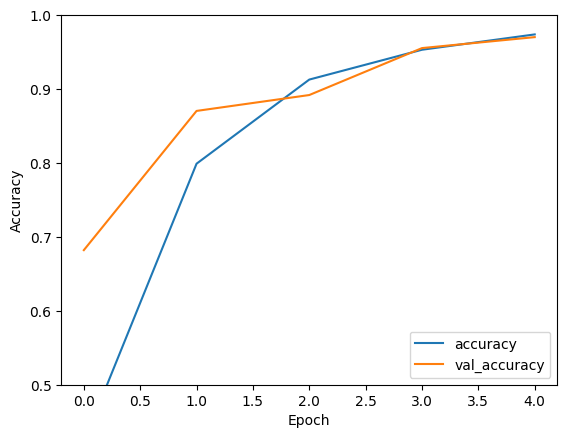

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_testHot, verbose=2)